# <center>Eclipse Integration </center>

### PortPy generates optimal fluences for IMRT plans that are compatible with the Eclipse system. This compatibility enables users to import the PortPy plan into the FDA-approved Eclipse system for a final clinical evaluation and comparisons with benchmark plans. This example outlines the following steps:


1. Creating a simple IMRT plan (Plan class, Optimization class)

2. Importing the PortPy plan into the Eclipse system for final leaf sequesing and dose calculation (Utils class)

3. Exporting the finally calculated dose from the Eclipse system (in DICOM RT-Dose format) into PortPy (Utils class)

4. Addressing the issue of dose discrepancy and demonstrating the correction steps to mitigate it

5. Comparing the PortPy plan against the benchmark IMRT plan for validation and analysis 


In [1]:
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import os
import matplotlib.pyplot as plt
import cvxpy as cp

### 1) Creating a simple IMRT plan (Plan class, Optimization class)


In [3]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# Pick a patient 
data.patient_id = 'Lung_Patient_2'
# Load ct, structure set, beams for the above patient using CT, Structures, and Beams classes
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
# Pick a protocol
protocol_name = 'Lung_2Gy_30Fx'
# Load clinical criteria for a specified protocol
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Load hyper-parameter values for optimization problem for a specified protocol
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# Create optimization structures (i.e., Rinds) 
structs.create_opt_structures(opt_params=opt_params)
# Load influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# Create a plan using ct, structures, beams and influence matrix, and clinical criteria
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

# Create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params, clinical_criteria=clinical_criteria)
opt.create_cvxpy_problem()
# Solve the cvxpy problem using Mosek
sol = opt.solve(solver='MOSEK', verbose=False)

creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 80.16471928842523
Elapsed time: 150.87714767456055 seconds


### 2) Importing the PortPy plan into the Eclipse system
The method *get_eclipse_fluence* stores the optimal fluence for each beam in a text file that can be imported into the Eclipse system. Please follow these steps to proceed:

1- Import the patient's data into the Eclipse system. This includes CT images and RT structures that are not included in the PortPy dataset and need to be downloaded from the [TCIA website](https://www.cancerimagingarchive.net/access-data/). The user can obtain the *TCIA collection ID* and *TCIA subject ID* using *get_tcia_metadata()* method in PortPy. 

2- Create beams identical to those used during the optimization. If you used the default beams, you could import the benchmark IMRT plan (DICOM RT-Plan) provided in the PortPy dataset. PortPy uses the same beams as those in the benchmark IMRT plan by default.

3- Within the Eclipse system, right-click on each field and choose 'Import Optimal Fluence', as demonstrated in the figure below. Select the optimal fluence text file generated by PortPy for each field.

4- Finally, in Eclipse, execute the final leaf sequencing and dose calculation.

<div>
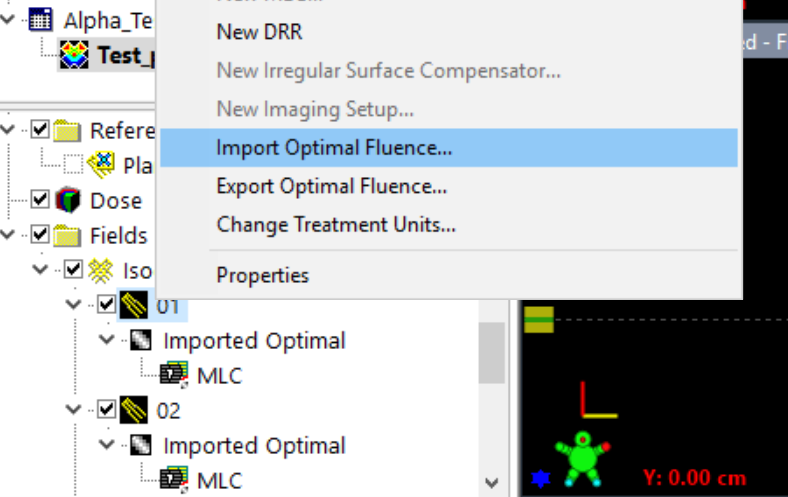
</div>



In [4]:
# get the corresponding tcia collection/subject ID
data.get_tcia_metadata()

{'portpy_patient_id': 'Lung_Patient_2', 'subject_id': 'LUNG1-002', 'collection_id': 'NSCLC-Radiomics'}


In [4]:
# Generate and save the optimal fluence in a format compatible with the Eclipse system
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol, path=os.path.join(r'C:\temp', data.patient_id))

### 3) Exporting the finally calculated dose from the Eclipse system into PortPy
After the final dose calculation in Eclipse, export the dose in DICOM RT-Dose format using the Eclipse Export module. Then, utilize the following lines of code to convert the exported dose into the PortPy format for visualization or evaluation purposes

In [5]:
# Specify the location and name of the DICOM RT Dose file
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose.dcm')  
# Convert the DICOM dose into PortPy format
ecl_dose_3d = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d)

### 4)  Addressing the issue of dose discrepancy using the correction steps
Initially, there may be a dose discrepancy between the PortPy dose and the Eclipse dose. This discrepancy can be partly attributed to leaf sequencing and the fact that the optimal fluence map cannot be perfectly replicated using a limited number of segments. However, if the fluence is properly smoothed out during the optimization, this discrepancy is often minor. The primary source of the dose discrepancy is related to the truncation of the influence matrix. As demonstrated below, if the full dense influence matrix is used in PortPy for dose calculation, the dose discrepancy would be negligible. This issue can be mitigated using a correction step.

The main concept behind the correction step is to calculate the dose discrepancy, denoted as $\delta$, and incorporate it into the optimization to counterbalance its effects. Let's assume we are solving the following optimization problem, where the dense influence matrix $A$ is replaced by the truncated sparse version $S$:

$ 
\mathbf{x^*} = argmin f(S\mathbf{x}) + g(\mathbf{x})\\
h(S\mathbf{x}) \leq 0
$

After solving the above problem, we estimate the dose discrepancy between the full and sparse influence matrix as,

$ 
\delta = A\mathbf{x^*}-S\mathbf{x^*}
$
 
Next, we solve the following optimization problem:

$
\mbox{Minimize}: f(S\mathbf{x^*} + \delta)+g(\mathbf{x^*})\\
\mbox{s.t}
\quad \quad h(S\mathbf{x^{*}} + \delta) \leq 0
$

This process may need to be repeated for several iterations or until $\delta$ is small. Instead of calculating the accurate dose using the full dense influence matrix, one can use the final Eclipse dose in the calculation of the dose discrepancy. 


#### Large Dose Discrepancy: Observed when using the truncated sparse influence matrix


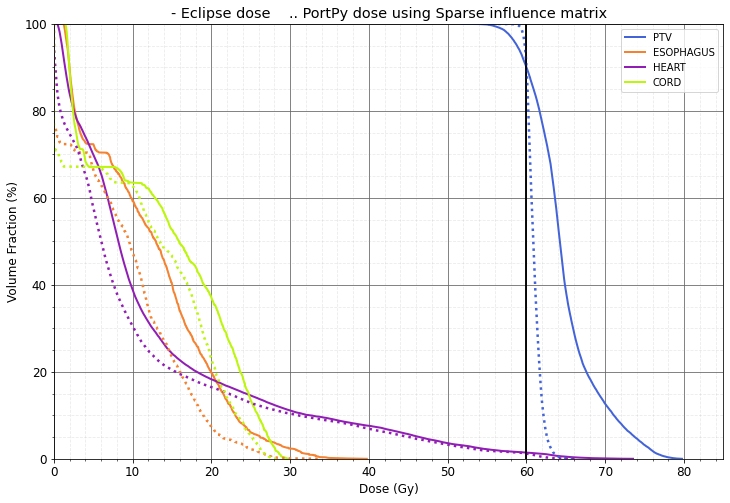

In [10]:
# Visualize the DVH discrepancy between sparse and full
dose_sparse_1d = inf_matrix.A @ (sol['optimal_intensity'] * my_plan.get_num_of_fractions())
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_sparse_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- Eclipse dose    .. PortPy dose using Sparse influence matrix')
ax.set_xlim(0,85)
plt.show()

#### Small Dose Discrepancy: Observed when using the full dense influence matrix

In [11]:
# load full influence matrix to calculate dose using full matrix
beams_full = pp.Beams(data, load_inf_matrix_full=True)
# load influence matrix based upon beams and structure set
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
dose_full_1d = inf_matrix_full.A @ (sol['optimal_intensity'] * my_plan.get_num_of_fractions()) # calculate dose using full matrix

Creating BEV..
Loading full influence matrix..
Done


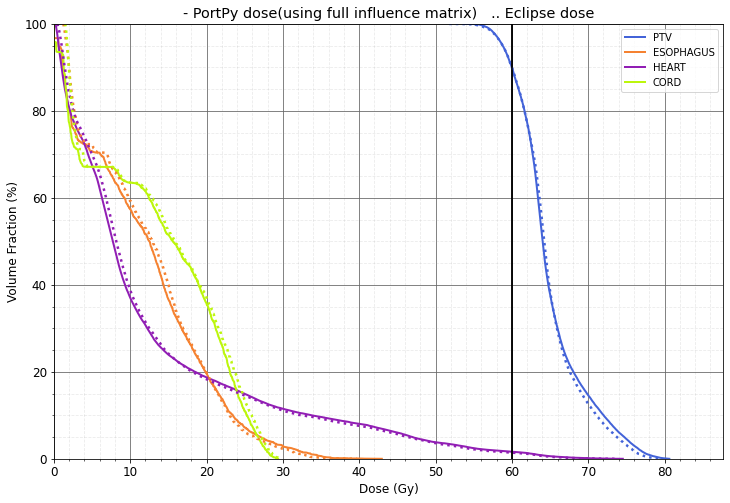

Done!


In [12]:
# Visualize the DVH discrepancy between eclipse dose and dose using full matrix in portpy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- PortPy dose(using full influence matrix)   .. Eclipse dose')
plt.show()
print('Done!')

#### Dose Correction

In [13]:
# calculating delta
# normalize both the dose to PTV:V(100%) = 90%
norm_volume = 90
norm_struct = 'PTV'
pres = my_plan.get_prescription()

norm_factor_sparse = pp.Evaluation.get_dose(sol, dose_1d=dose_sparse_1d, struct=norm_struct, volume_per=norm_volume) / pres
dose_sparse_1d_norm = dose_sparse_1d / norm_factor_sparse

norm_factor_full = pp.Evaluation.get_dose(sol, dose_1d=dose_full_1d, struct=norm_struct, volume_per=norm_volume) / pres
dose_full_1d_norm = dose_full_1d / norm_factor_full

delta = (dose_full_1d_norm - dose_sparse_1d_norm)/my_plan.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 61.66176753331044
Elapsed time: 239.15013027191162 seconds


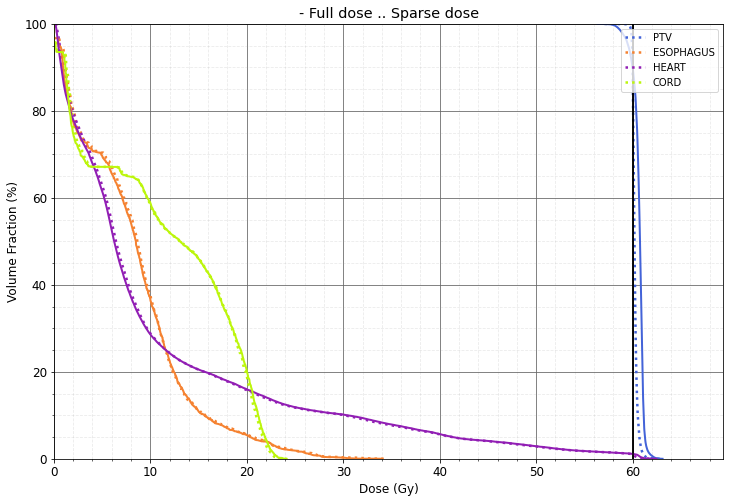

Done!
Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 60.93564776744375
Elapsed time: 250.08711767196655 seconds


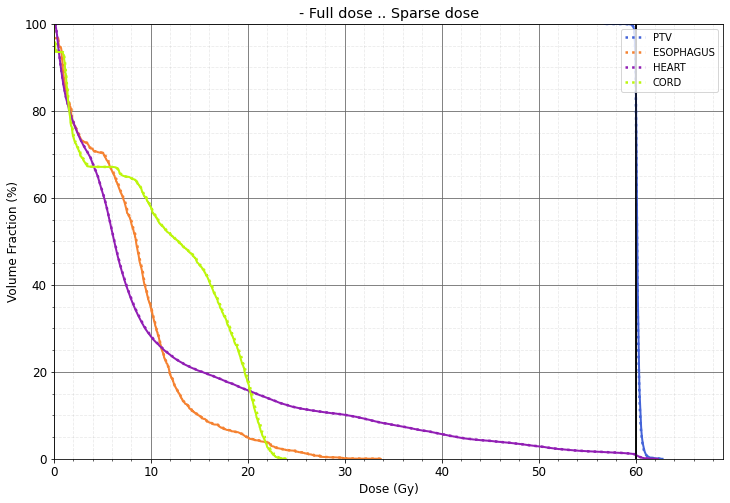

Done!


In [14]:
# Building up the correction model. It is the same opitmization problem but with corrected dose
# get opt params for optimization
old_delta = delta
num_corr = 2
for i in range(num_corr):

    A = inf_matrix.A
    opt = pp.Optimization(my_plan, opt_params=opt_params, clinical_criteria=clinical_criteria)
    opt.create_cvxpy_problem_correction(delta=delta) # input delta
    sol_corr = opt.solve(solver='MOSEK', verbose=False)
    
    dose_sparse_corr_1d = (inf_matrix.A @ sol_corr['optimal_intensity'] + delta) * my_plan.get_num_of_fractions()
    dose_full_corr_1d = inf_matrix_full.A @ (sol_corr['optimal_intensity'] * my_plan.get_num_of_fractions())
    
    # recalculate delta
    norm_volume = 90
    norm_struct = 'PTV'
    pres = my_plan.get_prescription()

    norm_factor_sparse = pp.Evaluation.get_dose(sol, dose_1d=dose_sparse_corr_1d, struct=norm_struct, volume_per=norm_volume) / pres
    dose_sparse_corr_1d_norm = dose_sparse_corr_1d / norm_factor_sparse

    norm_factor_full = pp.Evaluation.get_dose(sol, dose_1d=dose_full_corr_1d, struct=norm_struct, volume_per=norm_volume) / pres
    dose_full_corr_1d_norm = dose_full_corr_1d / norm_factor_full

    delta = (dose_full_corr_1d_norm - dose_sparse_corr_1d_norm)/my_plan.get_num_of_fractions()
    
    # Visualize DVH in correction step
    struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_sparse_corr_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_corr_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
    ax.set_title('- Full dose .. Sparse dose')
    plt.show()
    print('Done!')
    delta = old_delta + delta
    old_delta = delta

As depicted in the above figure, the dose discrepancy between the sparse and full dose calculations is minimal when correction steps are applied. Now, we can proceed to import the optimal fluence into Eclipse 

In [15]:
# Save optimal fluence into Eclipse compatible format
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol_corr, path=os.path.join(r'C:\temp', data.patient_id))

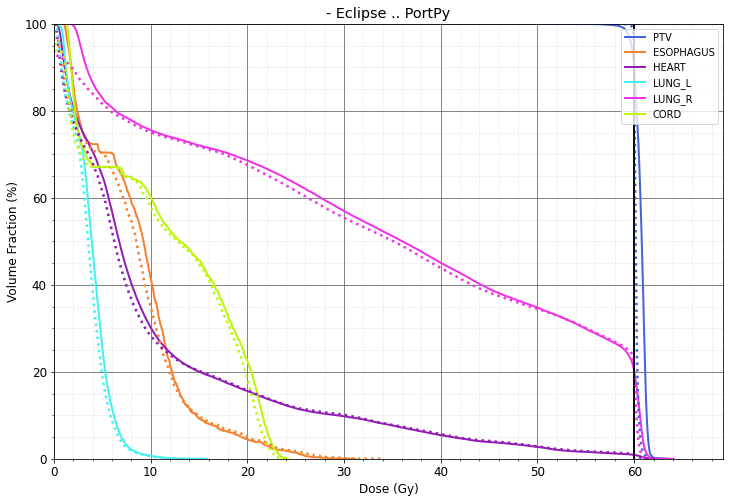

In [16]:
# After importing the optimal fluence into Eclipse and running full dose calculation, 
# we export the RT-Dose from Eclipse and convert it into PortPy format
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose_corr.dcm')  
ecl_dose_3d_corr = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d_corr = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d_corr)

# compare dvh of the optimized porptpy plan with the final plan in eclipse
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L','LUNG_R']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d_corr, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_sparse_corr_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- Eclipse .. PortPy')
plt.show()

### 5) Comparing the PortPy plan against the benchmark IMRT plan for validation and analysis
We can compare the PortPy-generated plan with the benchmark IMRT plan provided in the PortPy dataset. The benchmark IMRT plan is generated using the MSK in-house automated planning system ECHO ([YouTube Video](https://youtu.be/895M6j5KjPs), [paper](https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1002/mp.13572)). Before the comparison, we need to import the benchmark plan into Eclipse first. 

Below figure shows DVH comparison between PortPy generated plan (Triangle) and benchmark plan (Square) in the Eclipse system.
<div>
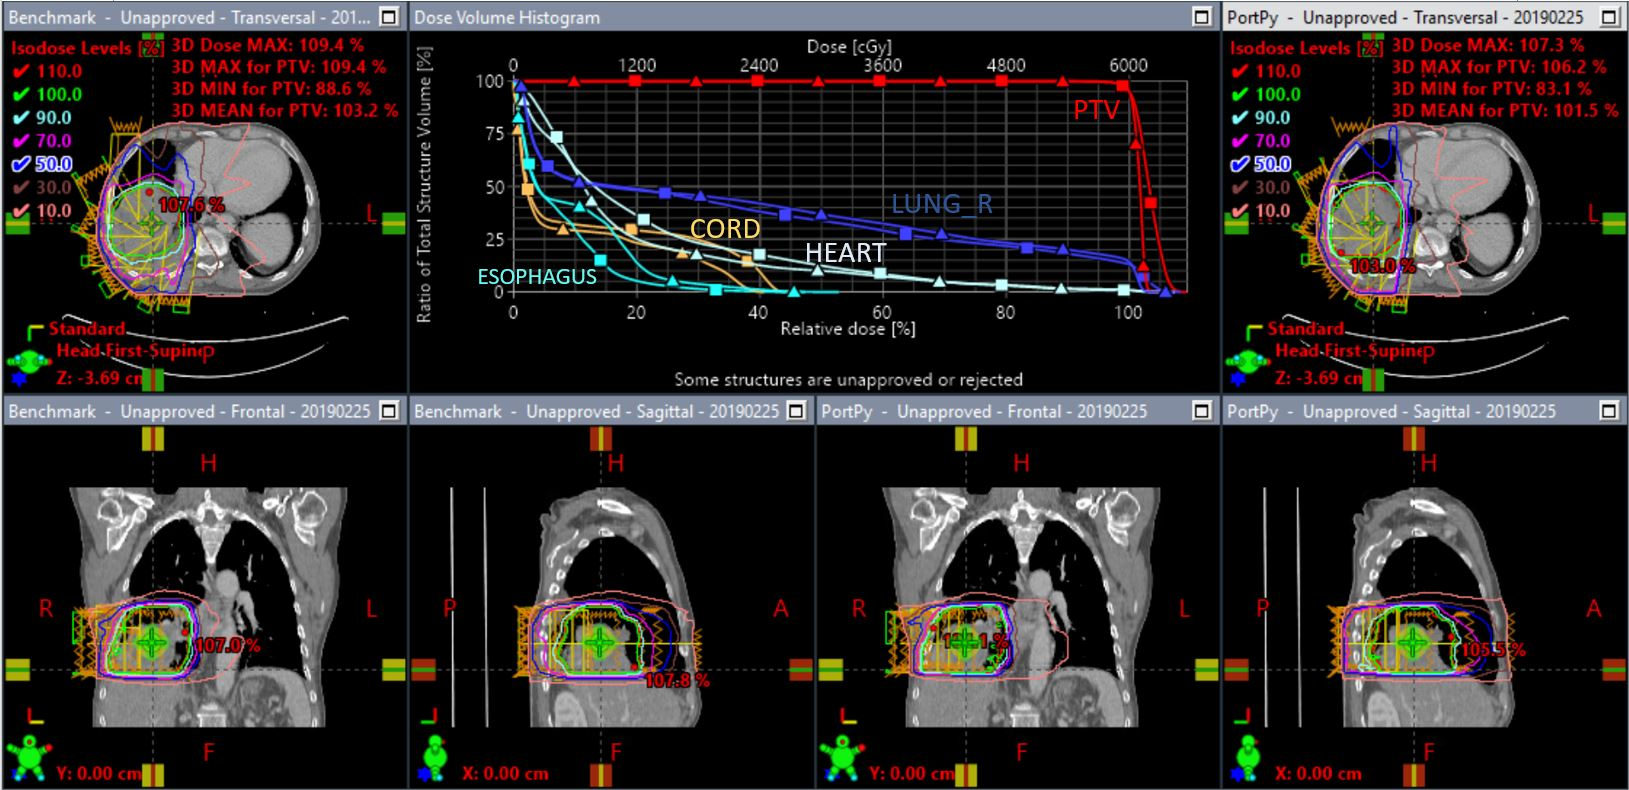
</div>